In [ ]:
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Affine Structure from Motion

## Overview


Recovers a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png.

The outline of the affine structure from motion algorithm:

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/sfm_algo.jpg" width="700"/>


In [ ]:
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
data = loadmat('/content/Part2_data/tracks.mat')

### Code

Motion matrix shape: (102, 3)
Shape matrix shape: (400, 3)


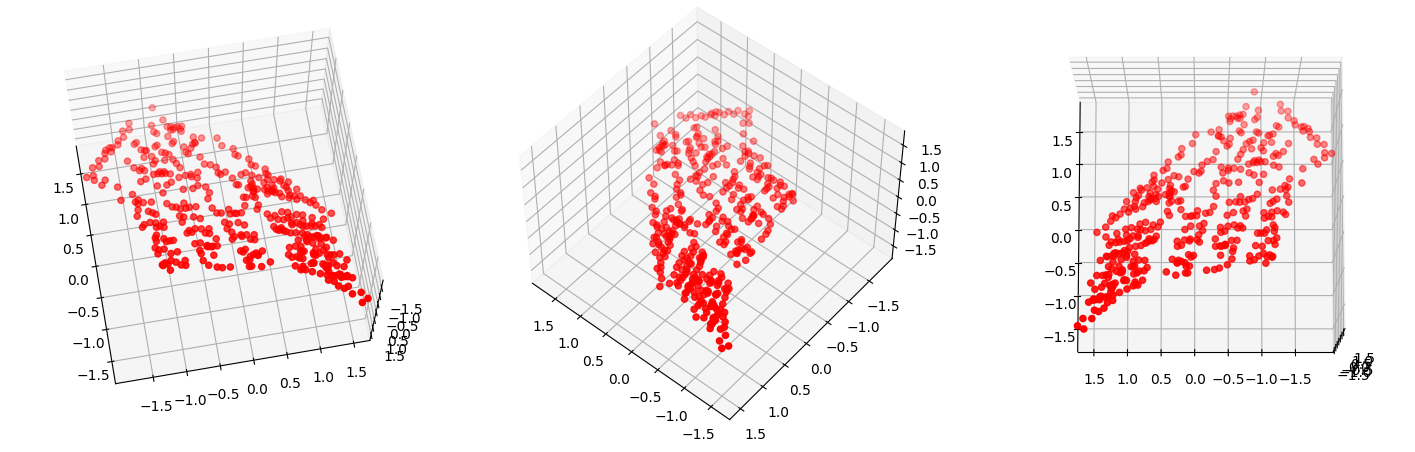

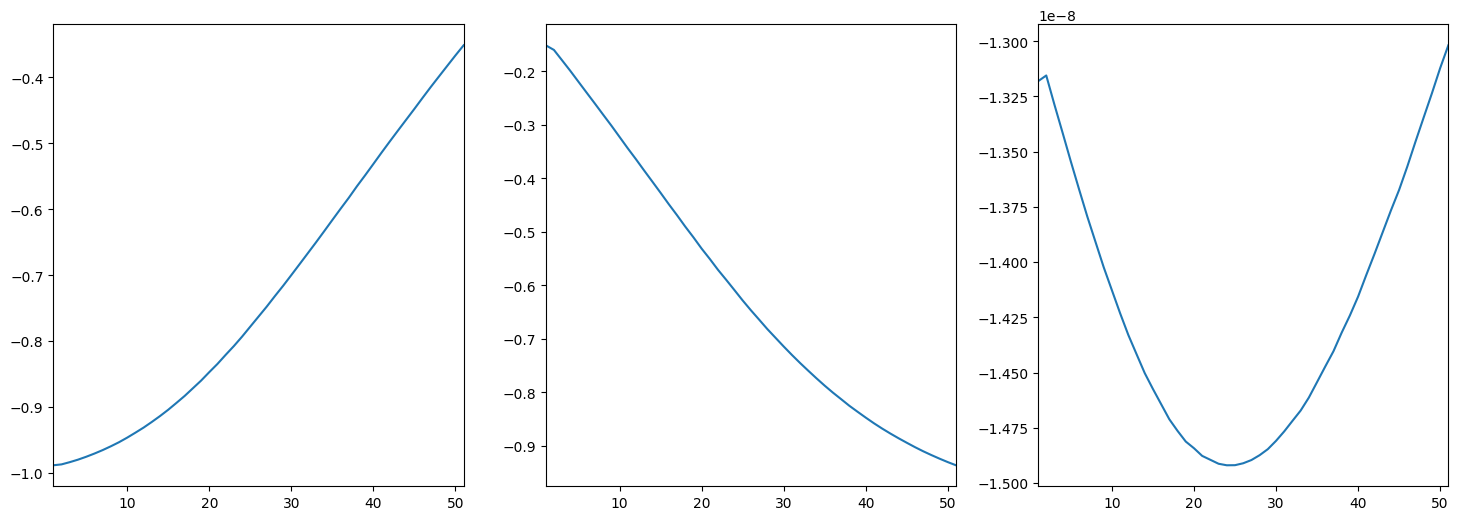

In [ ]:
from scipy.optimize import least_squares

track_x = data['track_x']
track_y = data['track_y']

# Remove the nan values
non_nan = ~np.isnan(track_x).any(axis=1) & ~np.isnan(track_y).any(axis=1)
track_x = track_x[non_nan, :]
track_y = track_y[non_nan, :]

def affineSFM(x, y):
  '''
  Function: Affine structure from motion algorithm
  '''
  x_new = x - np.mean(x, axis=0, keepdims=True)
  y_new = y - np.mean(y, axis=0, keepdims=True)

  x_new = x_new.T
  y_new = y_new.T

  D = np.vstack((x_new, y_new))

  U, W, VT = np.linalg.svd(D, False)
  U3 = U[:, :3]
  V3 = VT[:3, :]
  W3 = np.diag(W[:3])

  A = U3 @ np.sqrt(W3)
  S = V3.T @ np.sqrt(W3)

  def metric_constraints_helper(L):
      constraints = []
      for i in range(int(A.shape[0] // 2)):
          a_1 = A[i * 2, :]
          a_2 = A[i * 2 + 1, :]
          L_matrix = L.reshape((3, 3))
          constraints.append(a_1 @ L_matrix @ a_1 - 1)
          constraints.append(a_2 @ L_matrix @ a_2 - 1)
          constraints.append(a_1 @ L_matrix @ a_2)
      return constraints

  L_i = np.eye(3).flatten()
  ls = least_squares(metric_constraints_helper, L_i)
  L_optim = ls.x.reshape((3, 3))

  L_symm = (L_optim + L_optim.T) / 2

  eig = np.linalg.eigvalsh(L_symm)
  if np.all(eig > 0):
      C = np.linalg.cholesky(L_symm).T
  else:
      L_new = L_symm - (min(eig)) * np.eye(3)
      C = np.linalg.cholesky(L_new).T

  A = A @ np.linalg.inv(C)
  S = C @ S.T

  return A, S.T

motion, shape = affineSFM(track_x, track_y)
print("Motion matrix shape:", motion.shape)
print("Shape matrix shape:", shape.shape)

fig = plt.figure(figsize=(18, 6))
max_range = np.array([shape[:, 0].max() - shape[:, 0].min(),shape[:, 1].max() - shape[:, 1].min(),shape[:, 2].max() - shape[:, 2].min()]).max() / 2.0
mid_x_val = (shape[:, 0].max() + shape[:, 0].min()) * 0.5
mid_y_val = (shape[:, 1].max() + shape[:, 1].min()) * 0.5
mid_z_val = (shape[:, 2].max() + shape[:, 2].min()) * 0.5

view_angles = [(-110, 10), (50, 130), (80, 180)]

for i, (p1, p2) in enumerate(view_angles, 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.scatter(shape[:, 0], shape[:, 1], shape[:, 2], c='r', marker='o')
    ax.set_xlim(mid_x_val - max_range, mid_x_val + max_range)
    ax.set_ylim(mid_y_val - max_range, mid_y_val + max_range)
    ax.set_zlim(mid_z_val - max_range, mid_z_val + max_range)
    ax.view_init(elev=p1, azim=p2)

plt.show()

frames = motion.shape[0] // 2
#print("Frames", frames)
a_i = motion[:frames, :]
a_j = motion[frames:frames * 2, :]
a_k = np.cross(a_i, a_j)
a_k = a_k / np.linalg.norm(a_k, axis=1, keepdims=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
frame_nums= np.arange(1, frames + 1)

for i in range(3):
    ax[i].plot(frame_nums, a_k[:, i])
    ax[i].set_xlim(1, frames)

plt.show()